In [1]:
## from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter


import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

from collections import OrderedDict

import easygui

In [2]:
basedir = '\\\\depot.engr.oregonstate.edu\\users\\coe_apirate\\Windows.Documents\\Desktop\\Data'
sampledir = os.path.join(basedir,'20190128\Bi_A_2')
sampdict = {'s' :sampledir}

In [3]:
da_sw = load.sweeps2ds(sampdict)['Vsignal(V)']

In [4]:
direc = os.path.join(sampledir,'FreqFluence')
s_fps = load.freqfluence_flist(direc)
freqs = set(s_fps.index.levels[1])

no match for file TestSweep_psm_image.png


In [19]:
tup = ('U',8.532000e+09,5.5370010e+13)

tup in s_fps

False

In [3]:
fps = sampdict

das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    print('Loading data for ' + samp)
    s_fps = load.freqfluence_flist(direc)
#     print(s_fps)
    s,backvs = load.freqfluence_load(s_fps)
    print('Converting to Dataset')
    da = xr.DataArray.from_series(s)
    da = da.expand_dims('sample')
    da['sample'] = [samp]
    das.append(da)
    
    da_bv = xr.DataArray.from_series(backvs)
    da_bv = da_bv.expand_dims('sample')
    da_bv['sample'] = [samp]
    das_bv.append(da_bv)
    
da_dv = xr.concat(das, dim = 'sample')
da_dv = da_dv*(-1) #voltage is flipped
da_bv = xr.concat(das_bv,dim = 'sample')
print('done')

no match for file TestSweep_psm_image.png
Converting to Dataset
done


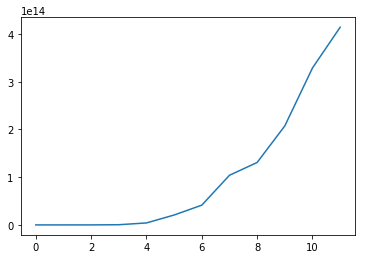

In [8]:
plt.plot(da_dv.indexes['fluence'])

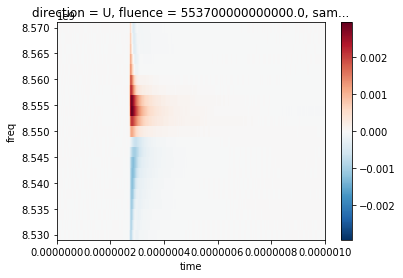

In [4]:
da_dv.sel(sample = 's').isel(fluence = -1).sel(direction = 'U').plot()

In [9]:
direc = os.path.join(fps['s'],'FreqFluence')
print(direc)
fpsdcs = load.freqdcs_flist(direc)
das = []

for direction,freqt in fpsdcs.index:
    fp = fpsdcs.loc[direction,freqt]
    s = load.loadsweep(fp,defaultV = 0.025)
    s = s.rename(s.name.replace(' ', ''))
    s.index = s.index.rename('freq')
    da = xr.DataArray.from_series(s)
    da = da.assign_coords(direction = direction).expand_dims('direction')
    da = da.assign_coords(freqt = freqt).expand_dims('freqt')
    das.append(da)
    
da_dcs = xr.merge(das)['Vsignal(V)']

\\depot.engr.oregonstate.edu\users\coe_apirate\Windows.Documents\Desktop\Data\20190128\Bi_A_2\FreqFluence


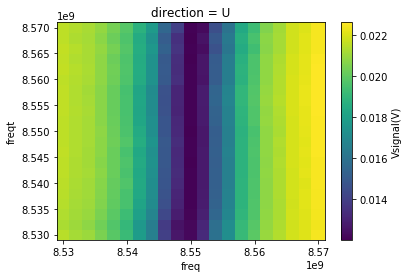

In [10]:
da_dcs.sel(direction = 'U').plot()

In [8]:
da

<xarray.DataArray 'Vsignal(V)' (freqt: 21, freq: 21)>
array([[0.02148 , 0.021192, 0.021032, ..., 0.021925, 0.022129, 0.022496],
       [0.021294, 0.021063, 0.020848, ..., 0.021869, 0.022117, 0.022425],
       [0.021378, 0.021171, 0.020985, ..., 0.021889, 0.022122, 0.022465],
       ...,
       [0.021639, 0.021437, 0.021251, ..., 0.02188 , 0.022151, 0.022501],
       [0.021579, 0.021343, 0.021186, ..., 0.021875, 0.022151, 0.022498],
       [0.021586, 0.021422, 0.021255, ..., 0.021882, 0.022068, 0.02247 ]])
Coordinates:
    direction  <U1 'U'
  * freqt      (freqt) float64 8.53e+09 8.532e+09 ... 8.568e+09 8.57e+09
  * freq       (freq) int64 8530000000 8532000000 ... 8568000000 8570000000

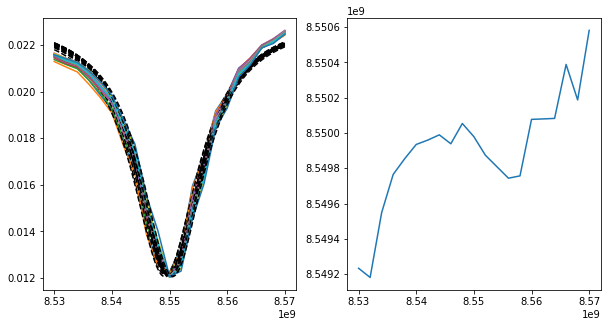

In [11]:
Rinf = 0.02125
f0 = 8.555e9
p0 =[f0,1e7,0.01, Rinf]
p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100

f0s = []

fig, axes = plt.subplots(1,2, figsize = (10,5))

da = da_dcs.sel(direction = 'U')

for freqt in da.indexes['freqt']:
    d = da.sel(freqt = freqt)
    axes[0].plot(d.to_series())

    v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
    f0s.append(v0_p[0])
    
    freqs = da.indexes['freq']
    freqs_i = np.linspace(freqs.min(),freqs.max(),100)
    dfit = v0_fit(freqs_i)
    dfit = pd.Series(dfit, index = freqs_i)
    axes[0].plot(dfit, color = 'black', linestyle = '--')
    
freqts = da.indexes['freqt']
    
axes[1].plot(freqts,f0s)